               X1       index          X2          X3          X4          X5  \
count  105.000000  105.000000  105.000000  105.000000  105.000000  105.000000   
mean    19.184174   53.000000   27.584512   19.046999  171.278720   96.247219   
std      4.554921   30.454885    8.253209    5.108853   44.837296   27.603938   
min     10.000000    1.000000   15.000000   10.965148  100.000000   51.000000   
25%     15.713442   27.000000   20.741344   14.420420  135.597089   74.291028   
50%     19.229284   53.000000   26.864507   19.270627  163.361219   95.543794   
75%     22.138543   79.000000   34.649355   22.912517  215.049975  123.479948   
max     27.688676  105.000000   41.966955   28.127924  252.515600  144.135439   

               X6          X7          X8          X9         X10  
count  105.000000  105.000000  105.000000  105.000000  105.000000  
mean   150.158699   82.173580   69.773834   41.945728   27.708968  
std     43.516579   22.854360   19.247796   11.594988    7.210807 

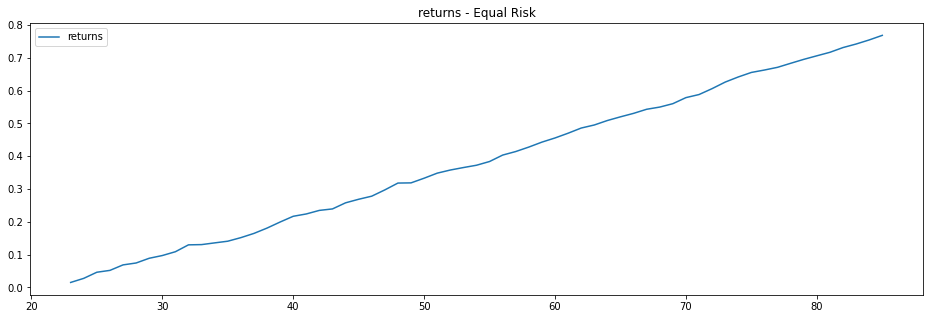

In [69]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#function was created to make the weights change according to the market
def automation_weight(retornos,w_vol):
    import numpy as np
    retornos=retornos.add(1)
    n=len(retornos)
    m=len(retornos.columns)
    pesos=np.zeros((n,m))
    weight=np.zeros((n,m))
    for i in range(len(retornos)):
        if i == 0:
            pesos[i,:] = w_vol
        else:
            weight[i,:] = (pesos[int(i-1),:]*(retornos.iloc[int(i-1)]))
            pesos[i,:]=weight[i,:]/sum(weight[i,:])

    return pesos

#list with the generating Y0's of each stock
lista_Y0=[10,15,11,100,51,78,42,39,22.2,15]
#using a loop to simulate the price series
#I estimate 5 months of series
n=5*21
#I use this for to fill a dataframe with simulated stock prices
#the first for generates the y0
#the second for generates the series of the random walk with drift, yt=alpha+yt-1+et
for i in range(len(lista_Y0)):
    y0=lista_Y0[i]
    # mean equals to 0
    valormedio = 0.0
    # standard deviation similar to the Brazilian stock market
    desviopadrao =0.0164620776332*y0
    alfa=0.0164620776332*y0
    np.random.seed(i)
    et= np.random.normal(loc=valormedio, scale=desviopadrao, size=n)

    price=pd.DataFrame({'X'+str(i+1):[y0]})
    for j in range(1,n):
        valor=alfa+price['X'+str(i+1)].iloc[j-1]+et[j]
        df=pd.DataFrame({'X'+str(i+1):[valor]})
        price=price.append(df)

    if i==0:
        price_data=pd.DataFrame({'X'+str(i+1):price['X'+str(i+1)]})
        price_data['index']=range(1,len(price)+1)

    else:
        price['index']=range(1,len(price)+1)
        price_data=price_data.merge(price,on='index',how='inner')


#I use pandas describe function to calculate descriptive statistics
descriptive_analysis=price_data.describe()
#I create a csv file with the dataframe descriptive_analysis to improve the appearance in excel
descriptive_analysis.to_csv('descriptive_analysis.csv')
print(descriptive_analysis)
#I create the dataframe port and the dataframe pesos_delta to store results
port=pd.DataFrame()
pesos_delta=pd.DataFrame()
#I create the days variables, to tell while true when to start the analysis
d_inicial=22
d_final=22+21*3
reb_days=[]
d_reb=d_inicial+21
#Important: I start on the 22nd to have days in the past to do risk analysis
#Inside while true: First, I create the first weights in each rebalancing,
# after that, I calculate the returns
# I use the function automation_weight
# I created automation_weight to vary the weights according to the market.
# The two main outputs in this loop are the portfolio returns, and the daily weights.
while True:
    d_reb=d_inicial+21
    if d_reb<=d_final:
        reb_days.append(d_inicial)
        d_vol=d_inicial-21
        volatility=price_data[(price_data['index']>=d_vol)&(price_data['index']<d_inicial)]
        volatility=volatility.set_index('index')
        volatility=volatility.pct_change()
        volatility=volatility.dropna(axis=0,how='any')
        volatility=volatility.std()
        inv_volatility=1/volatility
        first_weight=inv_volatility/sum(inv_volatility)
        first_weight=np.array(first_weight)

        returns=price_data[(price_data['index']>=d_inicial)&(price_data['index']<=d_reb)]
        returns=returns.set_index('index')
        returns=returns.pct_change()
        returns=returns.dropna(axis=0,how='any')
        weights=automation_weight(returns,first_weight)
        returns=returns*weights
        lista_names=list(returns.columns)
        returns['portfolio']=returns.sum(axis=1)
        lista_index = list(returns.index)
        pesos = pd.DataFrame(weights, index=lista_index)
        lista_numbers = list(pesos.columns)
        for i in range(len(lista_names)):
            pesos = pesos.rename(columns={lista_numbers[i]: lista_names[i]})

        df=pd.DataFrame({'portfolio':returns['portfolio']})
        port=port.append(df)
        pesos_delta=pesos_delta.append(pesos)

        d_inicial=d_inicial+21
    else:
        break
#I find out what the first weight is with the iloc[0] function
first_weight=pesos_delta.iloc[0]
#I create a csv file with the dataframe first_weight to improve the appearance in excel
first_weight.to_csv('firt_weight.csv')
pesos_delta=pesos_delta.reset_index()

delta_months=pd.DataFrame()
#I use for to find the delta weights.
# In other words, I find how much the trader needs to buy/sell to rebalance the portfolio.
for i in range(1,3):
    p=pesos_delta[(pesos_delta['index']>=reb_days[i])&(pesos_delta['index']<=(reb_days[i]+1))]
    p=p.set_index('index')
    delta=p.iloc[1]-p.iloc[0]
    df=pd.DataFrame({str(i+1)+'-month':delta})
    if i==1:
        delta_months=delta_months.append(df)
    else:
        delta_months=delta_months.merge(df,right_index=True,left_index=True,how='inner')

#I create a csv file with the dataframe delta_months to improve the appearance in excel
delta_months.to_csv('daemon_delta_months.csv')

#I calculate the accumulated return in the period
quote=port.add(1).cumprod().add(-1)
#I plot the accumulated return graph
plt.figure(figsize=(16,5))
plt.plot(quote,label='returns')
plt.legend(loc='upper left')
plt.title('returns - Equal Risk')
#I calculate some important indicators.
# such as : Sharpe, Return, Volatility, CAGR, Drawdown
sharpe=252*(port['portfolio'].mean()/port['portfolio'].std())
vol=port['portfolio'].std()*252**0.5
cum_return=quote['portfolio'].iloc[-1]
underwater_port = quote['portfolio'].div(quote['portfolio'].cummax())-1
maximum_drawdown_port = min(underwater_port)
cagr_port= (1+quote['portfolio'].iloc[-1])**(252/len(quote['portfolio']))-1
#I put the indicators in a dataframe
index=pd.DataFrame({'Return':[cum_return],'Volatility':[vol],'Sharpe':[sharpe],
                           'max_drawdown':[maximum_drawdown_port],'CAGR':[cagr_port]},
                          index=['Portfolio'])
#I create a csv file with the dataframe index to improve the appearance in excel
index.to_csv('index_returns.csv')